# Modeling and spatial prediction

In [1]:
%%capture
if 'google.colab' in str(get_ipython()):
    !pip install --quiet rioxarray
    !pip3 install xarray
    !pip3 install rasterio
    !pip install matplotlib-scalebar
    !pip install XlsxWriter
    !pip install shap
    !pip install fiona

In [2]:
import os
import fiona
import geopandas as gpd
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib.ticker as ticker
import matplotlib.colors as mcolors

# Sklearn
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import (train_test_split, KFold,
                                     LeaveOneGroupOut,LeaveOneOut,
                                     cross_validate)

from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.metrics import (mean_squared_error,r2_score,
                              mean_absolute_error,mean_absolute_percentage_error,
                              mean_squared_log_error )

# Initialize tools
scaler = StandardScaler()
le = LabelEncoder()


In [ ]:
# mount drive and get data paths
from google.colab import drive
drive.mount('/content/drive')
base_dir =  '/content/drive/MyDrive/Thesis/'
gpkg_path = '/content/drive/MyDrive/Thesis/Modelling/Data/GRP_Analysis.gpkg'

Database_gpkg = os.path.join(base_dir, 'Database.gpkg')
Model_data = os.path.join(base_dir, 'Model_data.gpkg')
master_data = gpd.read_file(gpkg_path, layer='Final_model_data')

print(f"Model_data: {fiona.listlayers(Model_data)}")
print(f"Database_gpkg: {fiona.listlayers(Database_gpkg)}")

In [4]:
#import numpy
#print(numpy.__version__)


In [5]:
# import custom scripts
import sys
sys.path.append(os.path.join(base_dir, 'scripts'))
import importlib

import modeling
importlib.reload(modeling)
from modeling import Metrics, predict_raster, fit_estimator_with_folds
metrics = Metrics()

import raster
importlib.reload(raster)
from raster import plot_raster_single

import Config
importlib.reload(Config)

from Config import (
    df_corr_columns_to_drop, df_corr_Geo_columns, seasonal_variables,
    columns_to_drop, feature_groups_list, rf_predictor_list, svr_predictor_list,
    gbr_predictor_list,rename_preds_dict, RenameUnit)

import Utils
importlib.reload(Utils)
from Utils import print_with_significant_figures

In [6]:
def remove_negative(df):
    numeric_cols = df.select_dtypes(include='number').columns
    df[numeric_cols] = df[numeric_cols].clip(lower=0)
    return df

#Load data
train_data = gpd.read_file(Model_data, layer='train_data')
test_data = gpd.read_file(Model_data, layer='test_data')
Final_data= gpd.read_file(Model_data, layer='Final_data')

datasets = [train_data, test_data, Final_data]
dfp = []
for dataset in datasets:
  df=dataset.copy()
  df = dataset.drop(columns_to_drop, axis=1).rename(columns= {'Rn_Poten':'GRP'})
  df = remove_negative(df)
  dfp.append(df)

train_sample, test_sample, Final_sample = dfp[0], dfp[1], dfp[2]
_Final_sample=Final_sample.copy()

group_column='grids_36k'
target_column='GRP'
#print(Final_data.shape)
#print(Final_sample.shape)

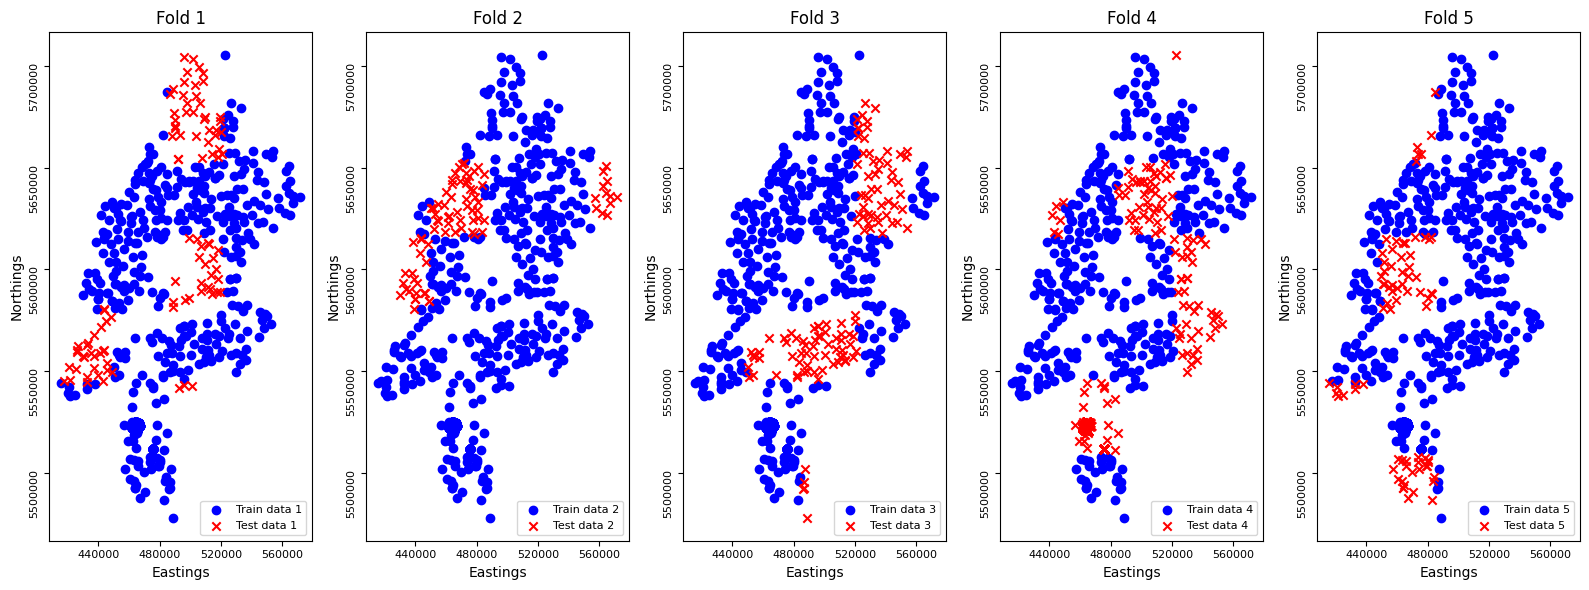

In [7]:
# Visualizing splits
training_data = train_data.copy()
loo = LeaveOneGroupOut()
n_splits = loo.get_n_splits(training_data, groups=training_data[group_column])
fig, axes = plt.subplots(nrows=1, ncols=n_splits, figsize=(16, 6))

splits = []  #store train/validation splits
for i, (train_idx, val_idx) in enumerate(loo.split(training_data, groups=training_data[group_column])):
    _train_data = training_data.iloc[train_idx].set_index(group_column)
    val_data = training_data.iloc[val_idx].set_index(group_column)
    splits.append((_train_data, val_data))

    ax = axes[i] if n_splits > 1 else axes
    ax.scatter(_train_data.OSTWERT, _train_data.NORDWERT, label=f'Train data {i+1}', color='blue')
    ax.scatter(val_data.OSTWERT, val_data.NORDWERT, label=f'Test data {i+1}', color='red', marker='x')
    ax.tick_params(axis='y', rotation=90)

    ax.xaxis.set_tick_params(labelsize=8)
    ax.yaxis.set_tick_params(labelsize=8)
    ax.xaxis.set_major_locator(ticker.MaxNLocator(5))
    ax.yaxis.set_major_locator(ticker.MaxNLocator(6))
    ax.ticklabel_format(style='plain')
    for label in ax.get_xticklabels():
      label.set_horizontalalignment('center')
    ax.legend(fontsize="8", loc="lower right")
    ax.set_title(f'Fold {i+1}')
    ax.set_xlabel('Eastings')
    ax.set_ylabel('Northings')

plt.tight_layout()
plt.show()

# Models

# RF

In [8]:
rf_final_predictors = train_sample[rf_predictor_list]
rf_final_predictors_test = test_sample[rf_predictor_list]

model_rf = fit_estimator_with_folds(
    rf_final_predictors,
    target_column,
    group_column,
    model_type='RandomForest',
    scale_data=True)
rf_trained = model_rf.train()

print(f"\n Training scores")
print_with_significant_figures(model_rf.get_avg_metrics_score())
print(" ")

print(f"\n Test scores")
rf_pre_obs, rf_val_results = model_rf.get_val_scores(rf_final_predictors_test)
print_with_significant_figures(rf_val_results)


 Training scores
                Score
RMSE           13.946
MSE           194.503
MAE             8.394
R^2             0.671
RMSLE           0.516
Adjusted R^2    0.479
 
 

 Test scores
                   Score
RMSE           20.431336
MSE           621.735523
MAE             8.320432
R^2             0.689213
RMSLE           0.653223
Adjusted R^2    0.612223


# GBR

In [9]:
gbr_final_predictors = train_sample[gbr_predictor_list]
gbr_final_predictors_test = test_sample[gbr_predictor_list]
model_gbrt = fit_estimator_with_folds(
    gbr_final_predictors,
    target_column,
    group_column,
    model_type='GBRT',
    scale_data=True)

gbr_trained = model_gbrt.train()

print(f"\n Training scores")
print_with_significant_figures(model_gbrt.get_avg_metrics_score())
print(" ")

print(f"\n Test scores")
gbr_pre_ob, gbr_val_results = model_gbrt.get_val_scores(gbr_final_predictors_test)
print_with_significant_figures(gbr_val_results)


 Training scores
                Score
RMSE           13.746
MSE           188.952
MAE             8.939
R^2             0.453
RMSLE           0.408
Adjusted R^2    0.417
 
 

 Test scores
                Score
RMSE           21.620
MSE           467.424
MAE            11.321
R^2             0.652
RMSLE           0.330
Adjusted R^2    0.593


# SVR

In [10]:
svr_final_predictors = train_sample[svr_predictor_list]
svr_final_predictors_test = test_sample[svr_predictor_list]

model_svr = fit_estimator_with_folds(
    svr_final_predictors,
    target_column,
    group_column,
    model_type='SVR',
    scale_data=True)
svr_trained = model_svr.train()

print(f"\n Training scores")
print_with_significant_figures(model_svr.get_avg_metrics_score())
print(" ")

print(f"\n Test scores")
svr_pre_obs, svr_val_results = model_svr.get_val_scores(svr_final_predictors_test)
print_with_significant_figures(svr_val_results)


 Training scores
                Score
RMSE           18.895
MSE           357.021
MAE             8.564
R^2             0.330
RMSLE           0.497
Adjusted R^2    0.259
 

 Test scores
                 Score
RMSE            32.934
MSE           1084.648
MAE             10.450
R^2              0.193
RMSLE            0.474
Adjusted R^2     0.119


# MLPR

In [11]:
mlpr_final_predictors = train_sample[rf_predictor_list]
mlpr_final_predictors_test = test_sample[rf_predictor_list]

model_mlpr = fit_estimator_with_folds(
    mlpr_final_predictors,
    target_column,
    group_column,
    model_type='MLPR',
    scale_data=False)
mlpr_trained = model_mlpr.train()

print(f"\n Training scores")
print_with_significant_figures(model_mlpr.get_avg_metrics_score())
print(" ")

print(f"\n Test scores")
mlpr_pre_obs, mlpr_val_results = model_mlpr.get_val_scores(mlpr_final_predictors_test)
print_with_significant_figures(mlpr_val_results)


 Training scores
 
                Score
RMSE           21.448
MSE           460.016
MAE            11.320
R^2             0.171
RMSLE           0.644
Adjusted R^2    0.140

 Test scores
                 Score
RMSE            32.546
MSE           1059.242
MAE             12.670
R^2              0.212
RMSLE            0.211
Adjusted R^2     0.140


# Spatial predictions

In [12]:
raster_path = '/content/drive/MyDrive/Thesis/Modelling/Data/Raster data'
rf_data = raster_path + '/Input raster/rf_predictors.tif'
svr_data = raster_path + '/Input raster/svr_predictors.tif'
gbm_data = raster_path + '/Input raster/gbm_predictors.tif'
MLP_data = raster_path + '/Input raster/rf_predictors.tif'

rf_predictor_feature_names = rf_final_predictors.drop(columns=['GRP','grids_36k'], axis=1)
svr_predictor_feature_names = svr_final_predictors.drop(columns=['GRP','grids_36k'], axis=1)
gbr_predictor_feature_names = gbr_final_predictors.drop(columns=['GRP','grids_36k'], axis=1)
MLP_predictor_feature_names = rf_final_predictors.drop(columns=['GRP','grids_36k'], axis=1)

In [13]:
# crate distinct cstom color
custom_brown_yellow_green = LinearSegmentedColormap.from_list(
    "custom_brown_yellow_green",
    [(0.0, 0.4, 0.0), (1.0, 1.0, 0.0), (0.6, 0.3, 0.1),(1.0, 1.0, 1.0)])
gradient = np.linspace(0, 1, 256).reshape(1, -1)

## RF map

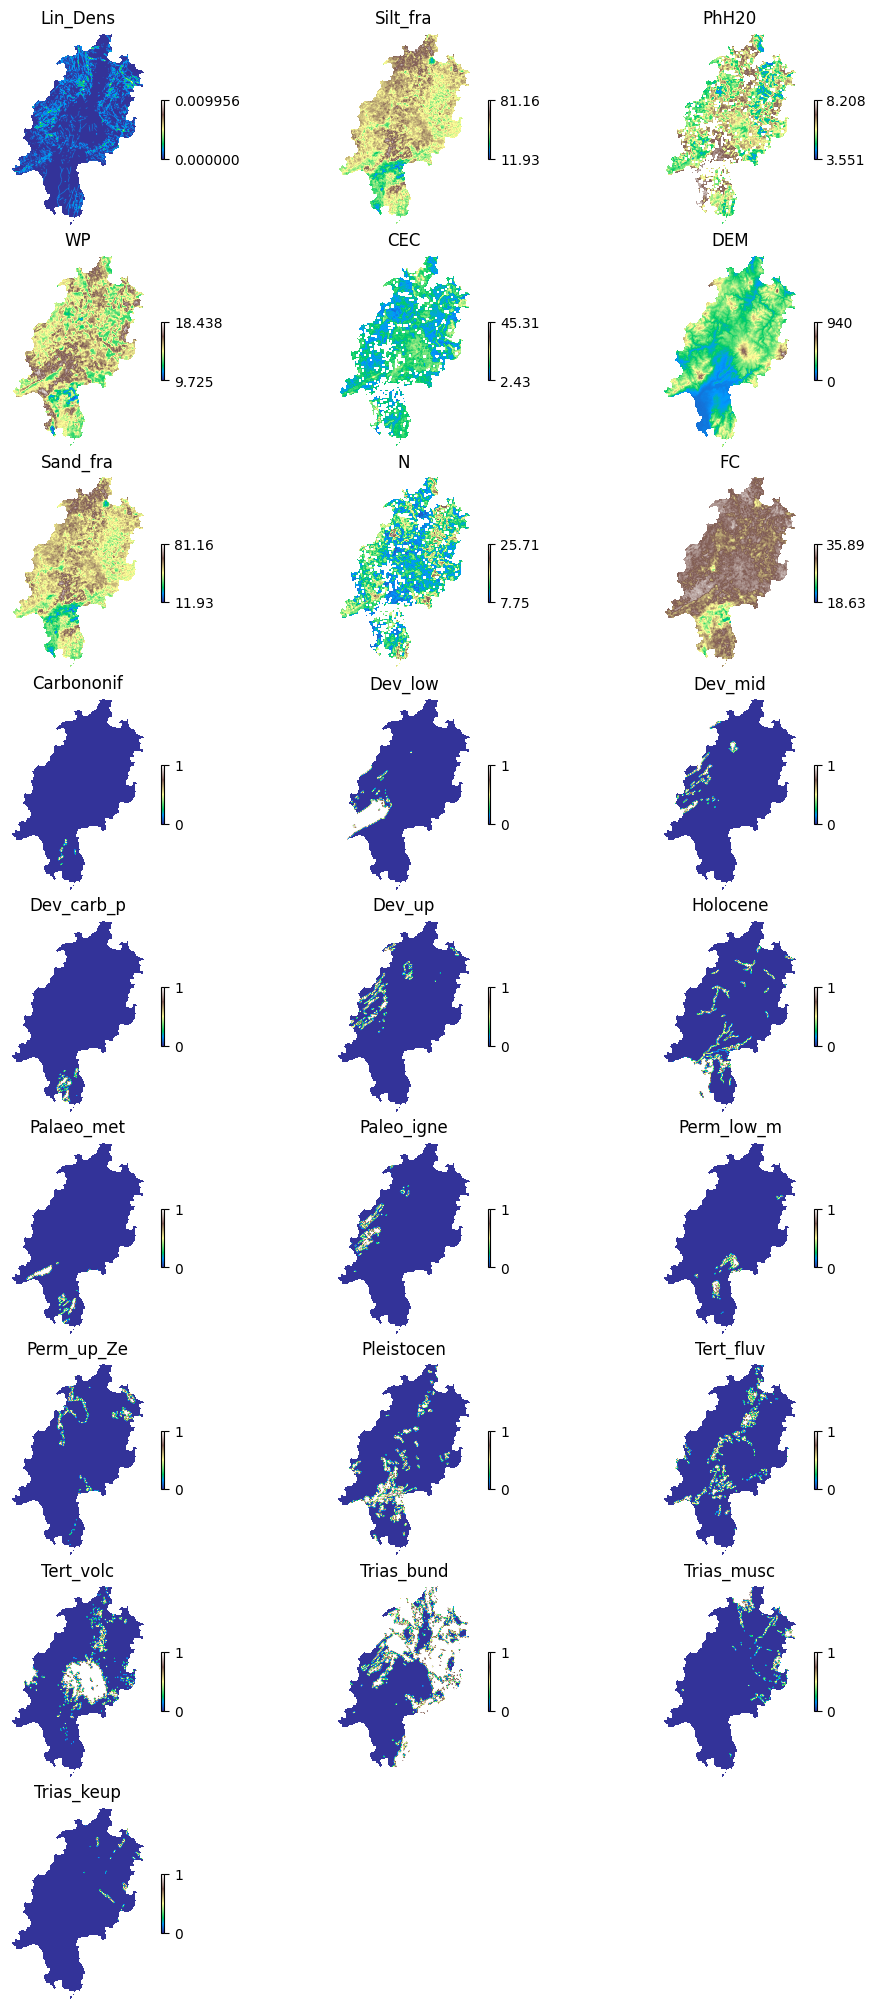

In [14]:
#processor = RenameUnit(Scaled_data_, 'hlnug')
#Scaled_data_updated = processor.process_geology_columns()

# rename labels to match stack
_rf_predictor_list = [rename_preds_dict.get(name, name) for name in rf_predictor_list]

#visualize the predictors of RF
raster_plotter = raster.RasterPlotter(colormap='terrain', figsize=(10, 20), columns=3)
raster_plotter.plot_raster_bands(rf_data, band_names=_rf_predictor_list[: len(_rf_predictor_list) - 2])

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names


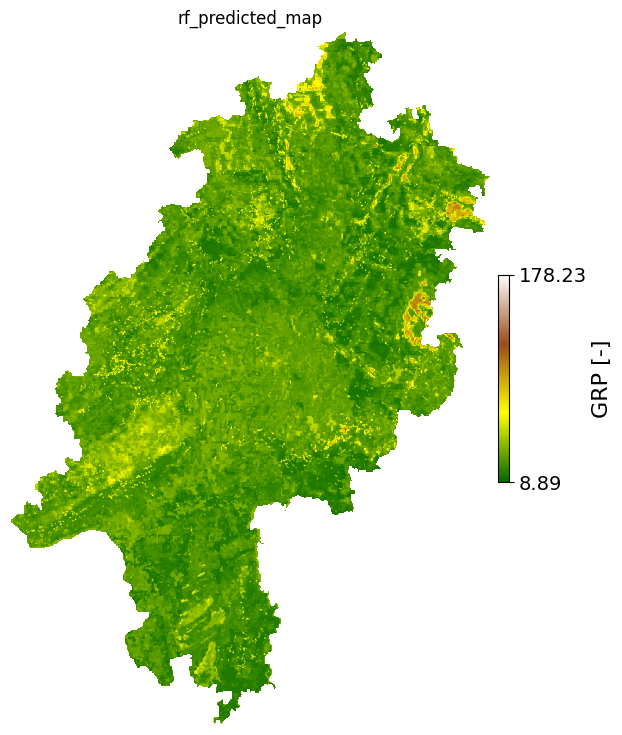

In [15]:
output_raster_path = '/content/drive/MyDrive/Thesis/Clean Thesis code/nrasters'
predicted_rff = output_raster_path +  '/rf_predicted_map.tif'
#rf_uncertainty = output_raster_path +  '/rf_uncertainty.tif'
#rf_trained = model_rf.train()
rf_map_predicted = predict_raster(rf_data, rf_trained, predicted_rff)

#Initialize plotter
mask_plotter= raster.RasterPlotter(colormap='terrain', figsize=(7, 6), columns=1)

# Plot predicted raster
mask_plotter.plot_raster_mask(predicted_rff)

## SVR map

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names


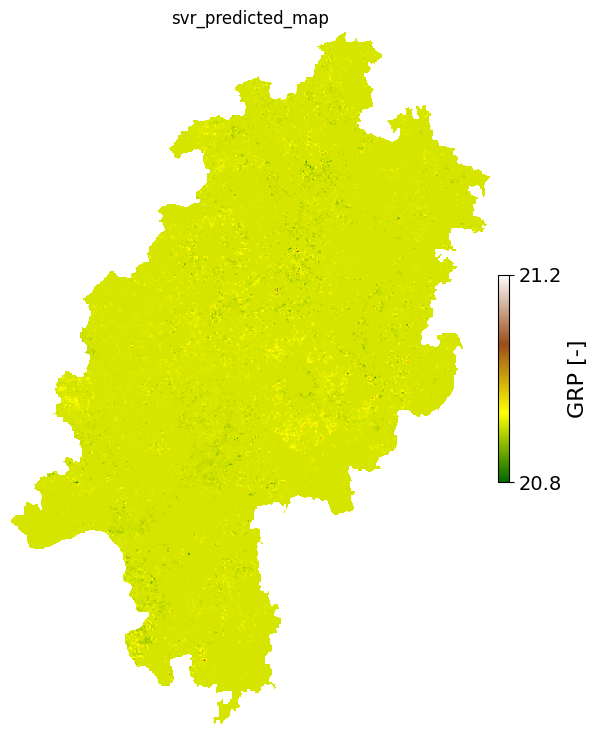

In [16]:
svr_data = raster_path + '/Input raster/svr_predictors.tif'
predicted_svrf = output_raster_path +  '/svr_predicted_map.tif'

# predict SVR
svr_map_predicted = predict_raster(svr_data, svr_trained, predicted_svrf)

#plot predicted SVR map
mask_plotter.plot_raster_mask(predicted_svrf)

## GBR map

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names


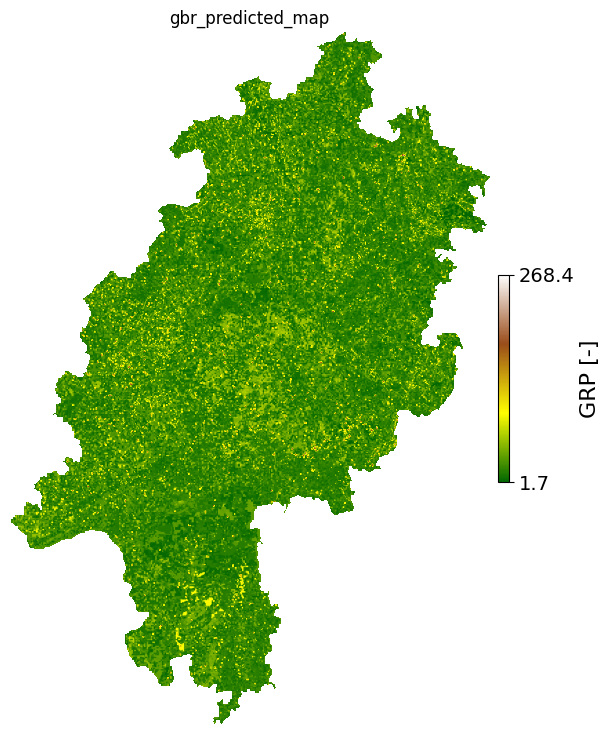

In [17]:
predicted_gbrf = output_raster_path +  '/gbr_predicted_map.tif'
gbr_map_predicted = predict_raster(gbm_data, gbr_trained, predicted_gbrf)

# plot predicted map
mask_plotter.plot_raster_mask(predicted_gbrf)

## MLPR map

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names


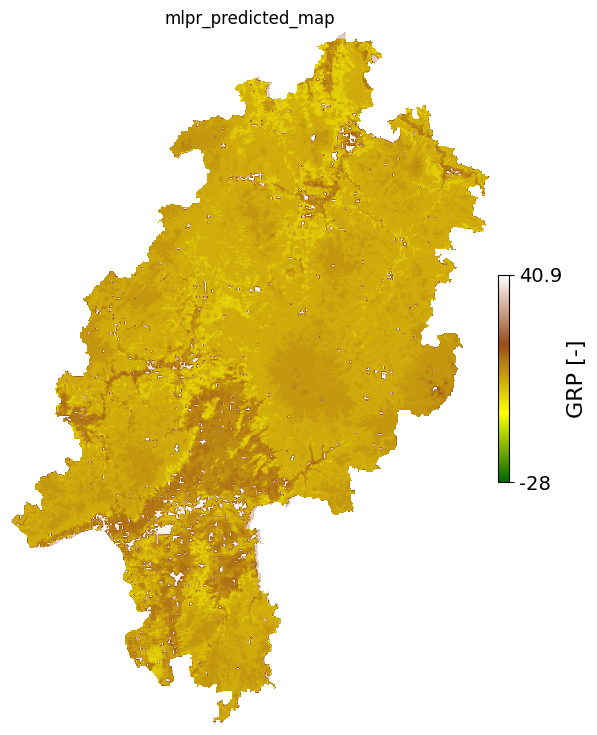

In [18]:
predicted_mlpr = output_raster_path +  '/mlpr_predicted_map.tif'

# predict map
mlpr_map_predicted = predict_raster(rf_data, mlpr_trained, predicted_mlpr)

# plot predicted map
mask_plotter.plot_raster_mask(predicted_mlpr)